In [194]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from tensorflow.python.keras import models
from keras.preprocessing.text import Tokenizer
# from keras.utils import pad_sequences
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, LSTM, Bidirectional, BatchNormalization
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint

import nltk
from nltk.corpus import stopwords
from nltk import ngrams
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
import seaborn as sns

# Load the Data

In [195]:
# dataset of IMDB reviews
df = pd.read_csv('IMDB Dataset.csv')
pd.set_option('display.max_colwidth', 100)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked....,positive
1,A wonderful little production. <br /><br />The filming technique is very unassuming- very old-ti...,positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air...",positive
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei off...",positive


In [196]:
# Has 2 columns: review and sentiment
# and has 50k rows
df.shape

(50000, 2)

In [197]:
df.nunique()

review       49582
sentiment        2
dtype: int64

In [198]:
# only 49582 unique reviews, so there are duplicates
df.drop_duplicates(inplace=True)
df.shape

(49582, 2)

In [199]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

# Visualize the Data

<AxesSubplot:xlabel='sentiment', ylabel='count'>

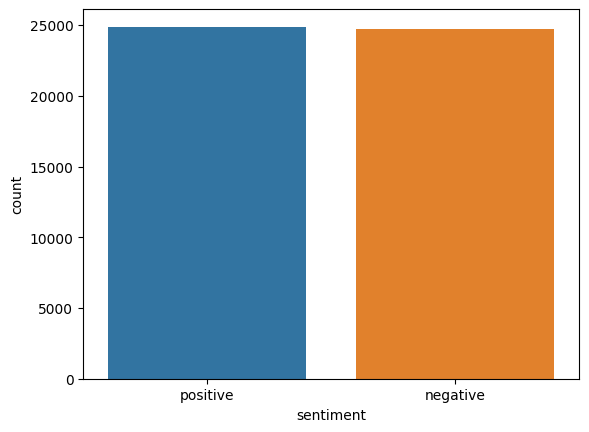

In [200]:
# plot histogram with total amount of positive and negative reviews
sns.countplot(x='sentiment', data=df)

Text(0.5, 1.0, 'Word Count per Negative Review')

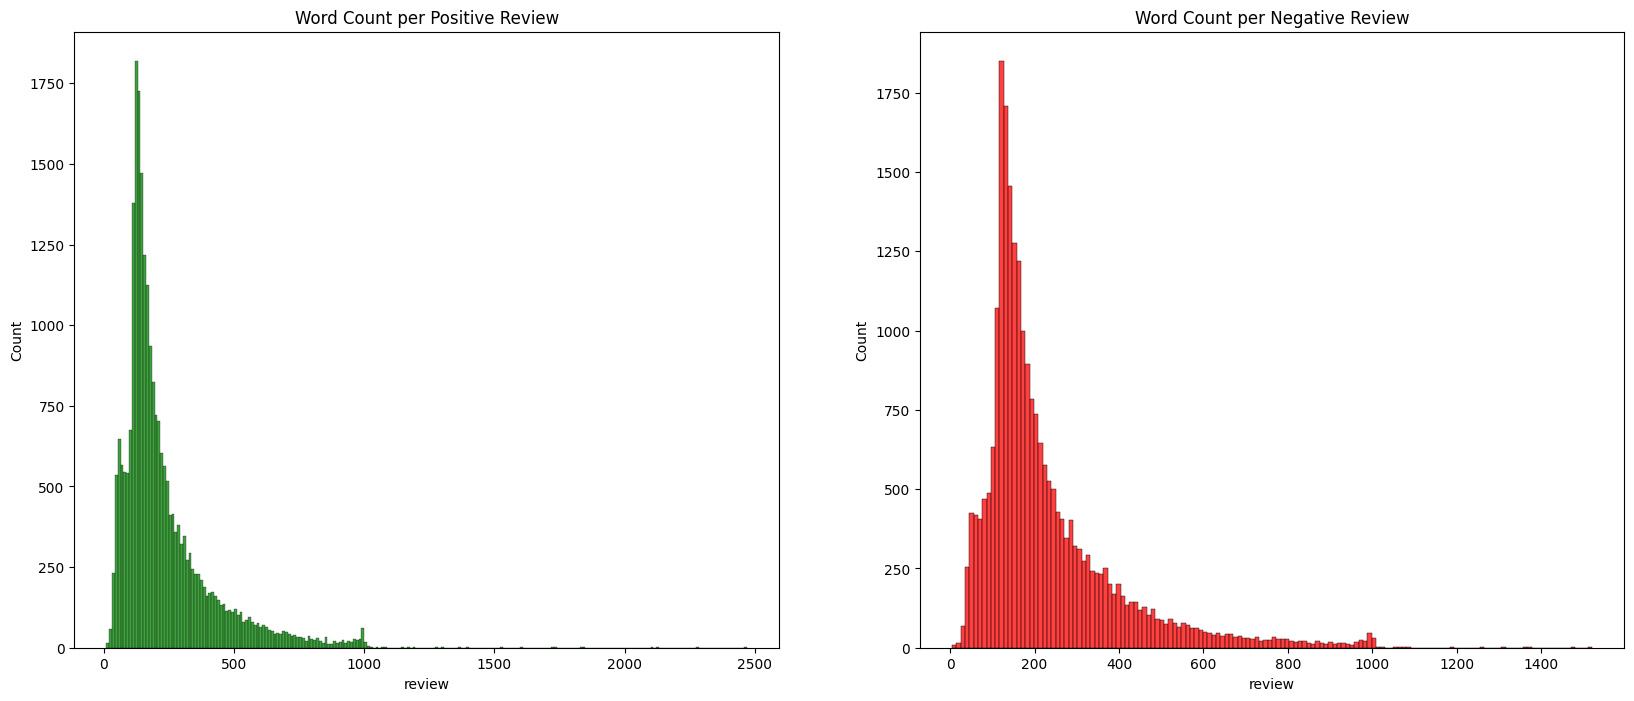

In [201]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20, 8))
# plot amount of words per review for positive reviews in subplot 1
sns.histplot(df[df['sentiment'] == 'positive']['review'].str.split().map(lambda x: len(x)), ax=ax1, label='Positive', color='green')
ax1.set_title('Word Count per Positive Review')
# plot amount of words per review for negative reviews in subplot 2
sns.histplot(df[df['sentiment'] == 'negative']['review'].str.split().map(lambda x: len(x)), ax=ax2, label='Negative', color='red')
ax2.set_title('Word Count per Negative Review')

In [202]:
# plot the most common words in the positive and negative reviews
def plot_most_common_words(df, sentiment, num_words=20):
    # get all the words in the reviews
    words = []
    for review in df[df['sentiment'] == sentiment]['review']:
        for word in review.split():
            words.append(word)
    
    # get the most common words
    most_common_words = pd.Series(words).value_counts()[:num_words]
    
    # plot the most common words
    plt.figure(figsize=(12, 8))
    sns.barplot(x=most_common_words, y=most_common_words.index)
    plt.title(f'Most common words in {sentiment} reviews')
    plt.xlabel('count')
    plt.ylabel('word')
    plt.show()

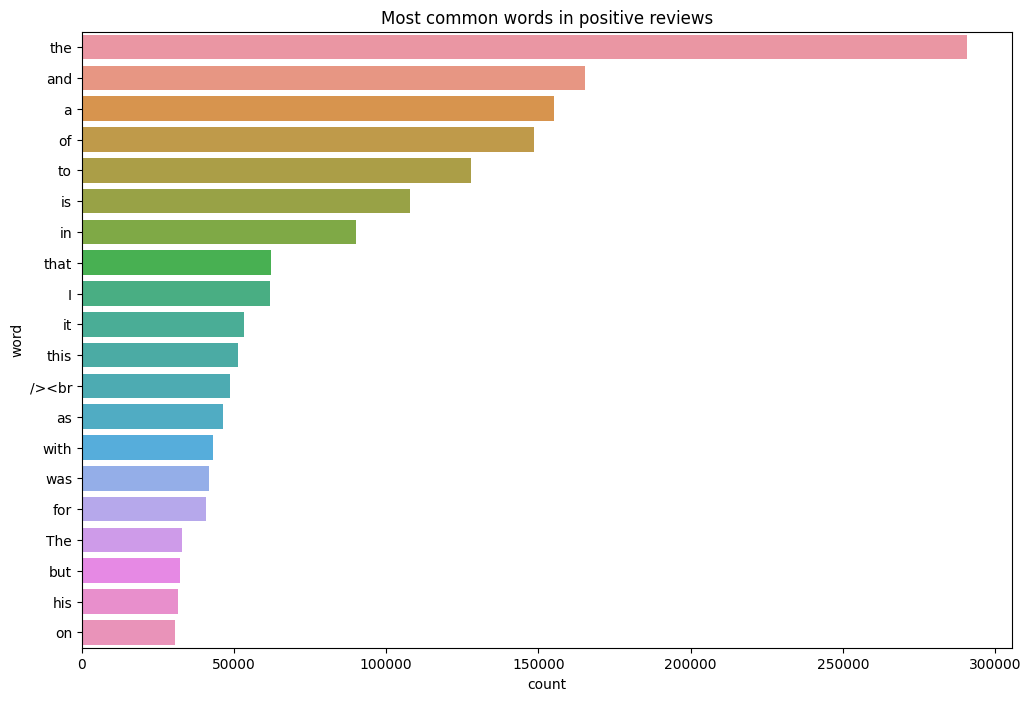

In [203]:
plot_most_common_words(df, 'positive')

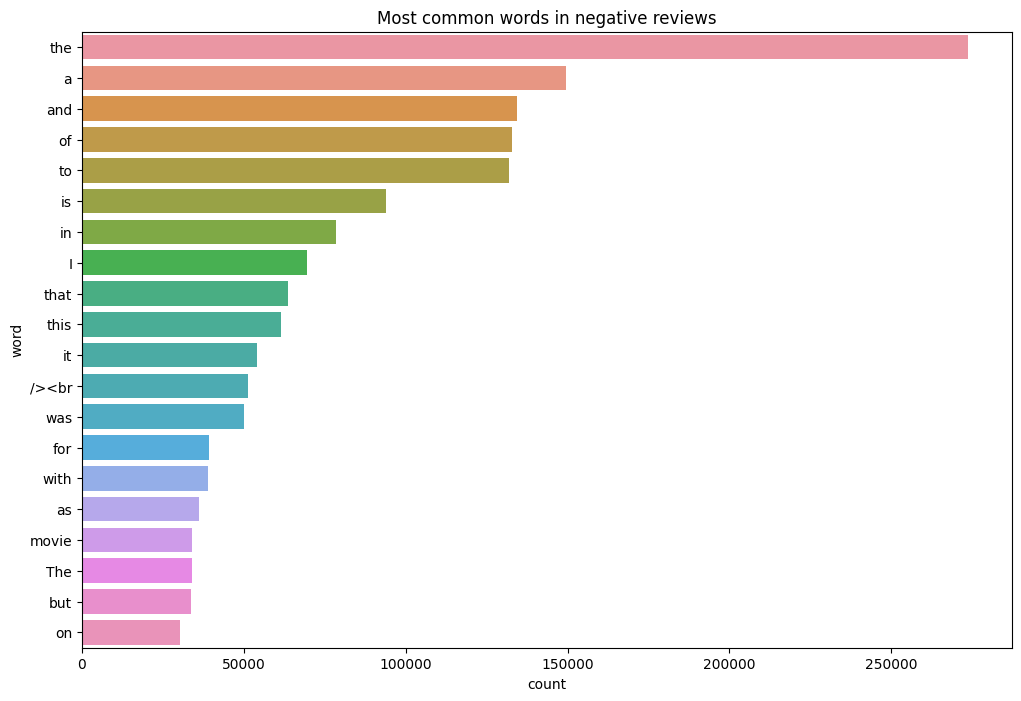

In [204]:
plot_most_common_words(df, 'negative')

In [205]:
def plot_most_common_ngrams(df, sentiment, n=2, num_ngrams=20):
    # get all the words in the reviews
    words = []
    for review in df[df['sentiment'] == sentiment]['review']:
        for word in review.split():
            words.append(word)
    
    # get the most common words
    most_common_ngrams = pd.Series(ngrams(words, n)).value_counts()[:num_ngrams]
    
    # plot the most common words
    plt.figure(figsize=(12, 8))
    sns.barplot(x=most_common_ngrams, y=most_common_ngrams.index)
    plt.title(f'Most common {n}-grams in {sentiment} reviews')
    plt.xlabel('count')
    plt.ylabel('word')
    plt.show()

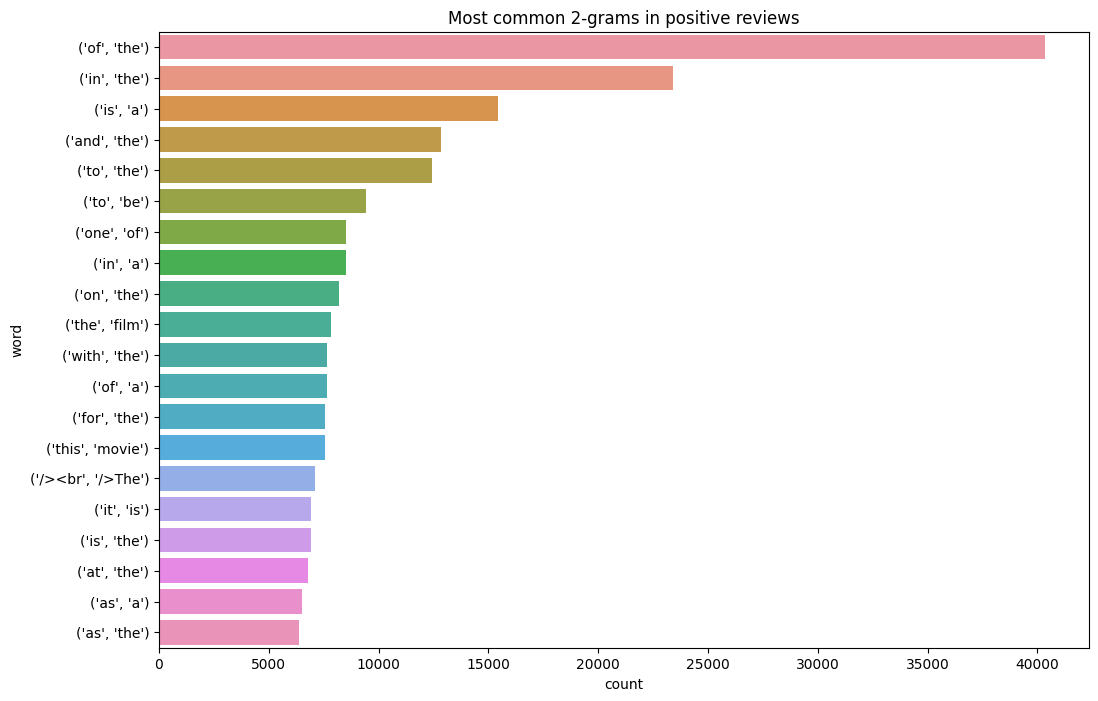

In [206]:
plot_most_common_ngrams(df, 'positive')

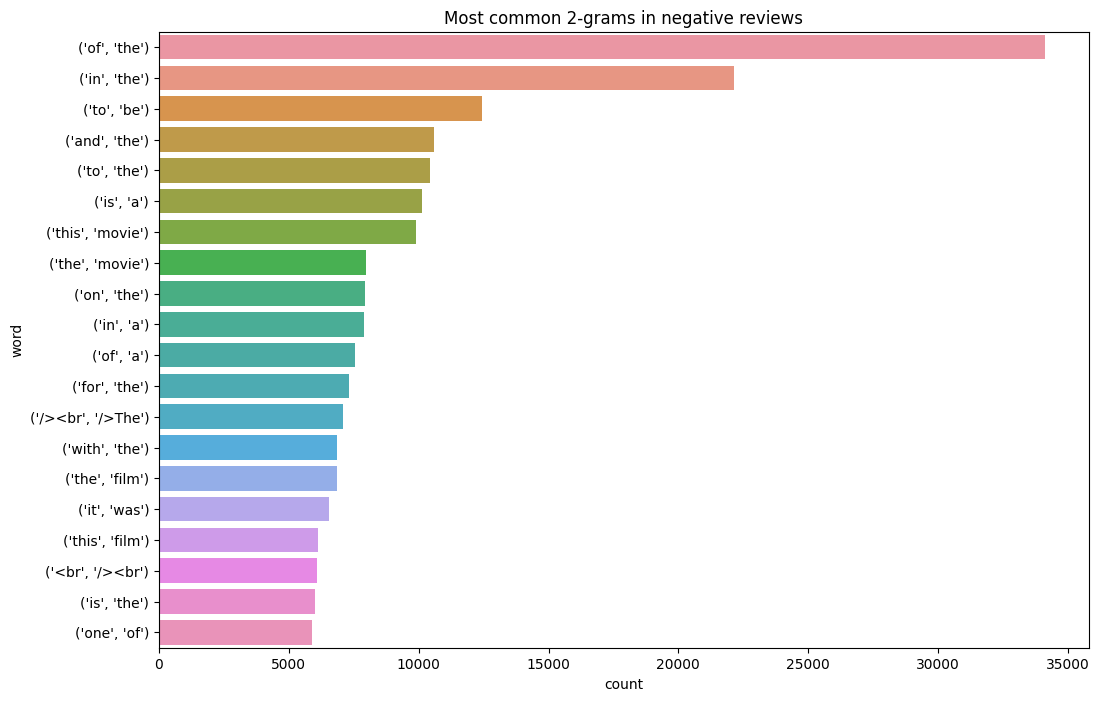

In [207]:
plot_most_common_ngrams(df, 'negative')

# Preprocess the Reviews Data

In [208]:
# remove abbreviations (i.eg. i'm -> i am, or hasn't -> has not)
def remove_abbreviations(text):
    # Credit: https://www.kaggle.com/abhilash1910 for the abbreviations lsit
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"there's", "there is", text)
    text = re.sub(r"We're", "We are", text)
    text = re.sub(r"That's", "That is", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"they're", "they are", text)
    text = re.sub(r"Can't", "Cannot", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"don\x89Ûªt", "do not", text)
    text= re.sub(r"aren't", "are not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"What's", "What is", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"There's", "There is", text)
    text = re.sub(r"He's", "He is", text)
    text = re.sub(r"It's", "It is", text)
    text = re.sub(r"You're", "You are", text)
    text = re.sub(r"I'M", "I am", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"i'm", "I am", text)
    text = re.sub(r"I\x89Ûªm", "I am", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r"Isn't", "is not", text)
    text = re.sub(r"Here's", "Here is", text)
    text = re.sub(r"you've", "you have", text)
    text = re.sub(r"you\x89Ûªve", "you have", text)
    text = re.sub(r"we're", "we are", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"we've", "we have", text)
    text = re.sub(r"it\x89Ûªs", "it is", text)
    text = re.sub(r"doesn\x89Ûªt", "does not", text)
    text = re.sub(r"It\x89Ûªs", "It is", text)
    text = re.sub(r"Here\x89Ûªs", "Here is", text)
    text = re.sub(r"who's", "who is", text)
    text = re.sub(r"I\x89Ûªve", "I have", text)
    text = re.sub(r"y'all", "you all", text)
    text = re.sub(r"can\x89Ûªt", "cannot", text)
    text = re.sub(r"would've", "would have", text)
    text = re.sub(r"it'll", "it will", text)
    text = re.sub(r"we'll", "we will", text)
    text = re.sub(r"wouldn\x89Ûªt", "would not", text)
    text = re.sub(r"We've", "We have", text)
    text = re.sub(r"he'll", "he will", text)
    text = re.sub(r"Y'all", "You all", text)
    text = re.sub(r"Weren't", "Were not", text)
    text = re.sub(r"Didn't", "Did not", text)
    text = re.sub(r"they'll", "they will", text)
    text = re.sub(r"they'd", "they would", text)
    text = re.sub(r"DON'T", "DO NOT", text)
    text = re.sub(r"That\x89Ûªs", "That is", text)
    text = re.sub(r"they've", "they have", text)
    text = re.sub(r"i'd", "I would", text)
    text = re.sub(r"should've", "should have", text)
    text = re.sub(r"You\x89Ûªre", "You are", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"Don\x89Ûªt", "Do not", text)
    text = re.sub(r"we'd", "we would", text)
    text = re.sub(r"i'll", "I will", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"They're", "They are", text)
    text = re.sub(r"Can\x89Ûªt", "Cannot", text)
    text = re.sub(r"you\x89Ûªll", "you will", text)
    text = re.sub(r"I\x89Ûªd", "I would", text)
    text = re.sub(r"let's", "let us", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"you're", "you are", text)
    text = re.sub(r"i've", "I have", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"i'll", "I will", text)
    text = re.sub(r"doesn't", "does not",text)
    text = re.sub(r"i'd", "I would", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"ain't", "am not", text)
    text = re.sub(r"you'll", "you will", text)
    text = re.sub(r"I've", "I have", text)
    text = re.sub(r"Don't", "do not", text)
    text = re.sub(r"I'll", "I will", text)
    text = re.sub(r"I'd", "I would", text)
    text = re.sub(r"Let's", "Let us", text)
    text = re.sub(r"you'd", "You would", text)
    text = re.sub(r"It's", "It is", text)
    text = re.sub(r"Ain't", "am not", text)
    text = re.sub(r"Haven't", "Have not", text)
    text = re.sub(r"Could've", "Could have", text)
    text = re.sub(r"youve", "you have", text)  
    text = re.sub(r"donå«t", "do not", text)  
    return text

df['review'] = df['review'].apply(lambda x: remove_abbreviations(x))

In [209]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lcano\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [210]:
stop_words = set(stopwords.words('english'))

df['review'] = df['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
df.head()

,review,sentiment
0,"One reviewers mentioned watching 1 Oz episode hooked. They right, exactly happened me.<br /><br ...",positive
1,A wonderful little production. <br /><br />The filming technique unassuming- old-time-BBC fashio...,positive
2,"I thought wonderful way spend time hot summer weekend, sitting air conditioned theater watching ...",positive
3,Basically family little boy (Jake) thinks zombie closet & parents fighting time.<br /><br />This...,negative
4,"Petter Mattei's ""Love Time Money"" visually stunning film watch. Mr. Mattei offers us vivid portr...",positive


In [211]:
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)
def remove_punctuation(text):
    punctuation = re.compile(r'[^\w\s]')
    return punctuation.sub(r' ', text)
def remove_links(text):
    links = re.compile(r'https://\S+|www\.\S+')
    return links.sub(r'', text)
def remove_emojis(text):
    emojis =re.compile("["
            u"\U0001F600-\U0001F64F"  
            u"\U0001F300-\U0001F5FF"  
            u"\U0001F680-\U0001F6FF"  
            u"\U0001F1E0-\U0001F1FF"  
            u"\U00002702-\U000027B0"
            u"\U000024C2-\U0001F251"
            "]+", flags=re.UNICODE)
    return emojis.sub(r'', text)

In [212]:
df['review'] = df['review'].apply(lambda x: remove_html(x))
df['review'] = df['review'].apply(lambda x: remove_punctuation(x))
df['review'] = df['review'].apply(lambda x: remove_links(x))
df.head()

,review,sentiment
0,One reviewers mentioned watching 1 Oz episode hooked They right exactly happened me The first ...,positive
1,A wonderful little production The filming technique unassuming old time BBC fashion gives comf...,positive
2,I thought wonderful way spend time hot summer weekend sitting air conditioned theater watching ...,positive
3,Basically family little boy Jake thinks zombie closet parents fighting time This movie slowe...,negative
4,Petter Mattei s Love Time Money visually stunning film watch Mr Mattei offers us vivid portr...,positive


In [213]:
# add <start> and <end> tokens to the reviews
df['review'] = df['review'].apply(lambda x: '<start> ' + x + ' <end>')
pd.set_option('display.max_colwidth', 800)
df.head()

,review,sentiment
0,<start> One reviewers mentioned watching 1 Oz episode hooked They right exactly happened me The first thing struck Oz brutality unflinching scenes violence set right word GO Trust me show faint hearted timid This show pulls punches regards drugs sex violence Its hardcore classic use word It called OZ nickname given Oswald Maximum Security State Penitentary It focuses mainly Emerald City experimental section prison cells glass fronts face inwards privacy high agenda Em City home many Aryans Muslims gangstas Latinos Christians Italians Irish more so scuffles death stares dodgy dealings shady agreements never far away I would say main appeal show due fact goes shows would dare Forget pretty pictures painted mainstream audiences forget charm forget romance OZ ...,positive
1,<start> A wonderful little production The filming technique unassuming old time BBC fashion gives comforting sometimes discomforting sense realism entire piece The actors extremely well chosen Michael Sheen has got polari voices pat too You truly see seamless editing guided references Williams diary entries well worth watching terrificly written performed piece A masterful production one great master s comedy life The realism really comes home little things fantasy guard which rather use traditional dream techniques remains solid disappears It plays knowledge senses particularly scenes concerning Orton Halliwell sets particularly flat Halliwell s murals decorating every surface terribly well done <end>,positive
2,<start> I thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy The plot simplistic dialogue witty characters likable even well bread suspected serial killer While may disappointed realize Match Point 2 Risk Addiction I thought proof Woody Allen still fully control style many us grown love This I would laughed one Woody s comedies years dare I say decade While I never impressed Scarlet Johanson managed tone sexy image jumped right average spirited young woman This may crown jewel career wittier Devil Wears Prada interesting Superman great comedy go see friends <end>,positive
3,<start> Basically family little boy Jake thinks zombie closet parents fighting time This movie slower soap opera suddenly Jake decides become Rambo kill zombie OK first going make film must Decide thriller drama As drama movie watchable Parents divorcing arguing like real life And Jake closet totally ruins film I expected see BOOGEYMAN similar movie instead watched drama meaningless thriller spots 3 10 well playing parents descent dialogs As shots Jake ignore them <end>,negative
4,<start> Petter Mattei s Love Time Money visually stunning film watch Mr Mattei offers us vivid portrait human relations This movie seems telling us money power success people different situations encounter This variation Arthur Schnitzler s play theme director transfers action present time New York different characters meet connect Each one connected one way another next person one seems know previous point contact Stylishly film sophisticated luxurious look We taken see people live world live habitat The thing one gets souls picture different stages loneliness one inhabits A big city exactly best place human relations find sincere fulfillment one discerns case people encounter The acting good Mr Mattei s direction Steve Buscemi Rosario Dawson Carol Kane Michael Im...,positive


In [214]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lcano\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\lcano\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [215]:
# Lemmatization of words to get the root word
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

df['review'] = df['review'].apply(lambda x: lemmatize_words(x))
pd.set_option('display.max_colwidth', 100)
df.head()

,review,sentiment
0,<start> One reviewer mentioned watching 1 Oz episode hooked They right exactly happened me The f...,positive
1,<start> A wonderful little production The filming technique unassuming old time BBC fashion give...,positive
2,<start> I thought wonderful way spend time hot summer weekend sitting air conditioned theater wa...,positive
3,<start> Basically family little boy Jake think zombie closet parent fighting time This movie slo...,negative
4,<start> Petter Mattei s Love Time Money visually stunning film watch Mr Mattei offer u vivid por...,positive


# Transforming the Data

In [216]:
# First of all change "positive" and "negative" to 1 and 0 respectively
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
df.head(5)

,review,sentiment
0,<start> One reviewer mentioned watching 1 Oz episode hooked They right exactly happened me The f...,1
1,<start> A wonderful little production The filming technique unassuming old time BBC fashion give...,1
2,<start> I thought wonderful way spend time hot summer weekend sitting air conditioned theater wa...,1
3,<start> Basically family little boy Jake think zombie closet parent fighting time This movie slo...,0
4,<start> Petter Mattei s Love Time Money visually stunning film watch Mr Mattei offer u vivid por...,1


In [217]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=42)

#Vectorizing data  

tfidf_vect = TfidfVectorizer() #tfidfVectorizer  
Xtrain_tfidf = tfidf_vect.fit_transform(Xtrain)  
Xtest_tfidf = tfidf_vect.transform(Xtest)  


count_vect = CountVectorizer() # CountVectorizer  
Xtrain_count = count_vect.fit_transform(Xtrain)  
Xtest_count = count_vect.transform(Xtest)  

In [218]:
# Tokenize texts
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
# Vocabulary
word_index = tokenizer.word_index
vocab_size = len(word_index)
print('Vocabulary size: {}'.format(vocab_size))

Vocabulary size: 89007


In [219]:
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [220]:
# Pad the sequences to have the same length to the average length of the sequences + 50
avg_len_train = int((sum([len(x) for x in train_sequences]) / len(train_sequences)) + 50)
train_padded = pad_sequences(train_sequences, maxlen=avg_len_train, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=avg_len_train, padding='post', truncating='post')

In [221]:
#Splitting training set for validation
Xtrain,Xval,ytrain,yval=train_test_split(train_padded,y_train,
                                             test_size=0.2,random_state=10)

In [223]:
# Make static Glove embeddings
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        embeddings_index[word] = np.asarray(values[1:], dtype='float32')

embedding_len = len(embeddings_index)
embedding_std = np.std(list(embeddings_index.values()))
embedding_mean = np.mean(list(embeddings_index.values()))
embedding_dim = 100

embedding_matrix = np.random.normal(embedding_mean, embedding_std, (vocab_size + 1, embedding_dim))
# embedding_matrix = np.zeros((vocab_size + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


# Creating the Model

In [224]:
modellist = []

In [225]:
# model1
model = Sequential()
model.add(Embedding(vocab_size + 1, embedding_dim, input_length=avg_len_train, weights=[embedding_matrix], trainable=False))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Conv1D(128, 7, activation='relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D())
model.add(Conv1D(256, 5, activation='relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D())
model.add(Conv1D(512, 3, activation='relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D())
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['acc'])
modellist.append(model)

In [226]:
# model2
model = Sequential()
model.add(Embedding(vocab_size + 1, embedding_dim, input_length=avg_len_train, weights=[embedding_matrix], trainable=False))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Conv1D(128, 5, activation='relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D())
model.add(Conv1D(256, 3, activation='relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D())
model.add(Conv1D(512, 3, activation='relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D())
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['acc'])
modellist.append(model)

In [227]:
# model3
model = Sequential()
model.add(Embedding(vocab_size + 1, embedding_dim, input_length=avg_len_train, weights=[embedding_matrix], trainable=False))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D())
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])
modellist.append(model)

In [228]:
# model4
model = Sequential()
model.add(Embedding(vocab_size + 1, embedding_dim, input_length=avg_len_train, weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1, return_sequences=True))
model.add(Conv1D(64, 7, activation='relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D())
model.add(Conv1D(128, 5, activation='relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['acc'])
modellist.append(model)

In [229]:
# model5
model = Sequential()
model.add(Embedding(vocab_size + 1, embedding_dim, input_length=avg_len_train, weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Conv1D(128, 5, activation='relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D())
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['acc'])
modellist.append(model)

In [230]:
# model6
model = Sequential()
model.add(Embedding(vocab_size + 1, embedding_dim, input_length=avg_len_train, weights=[embedding_matrix], trainable=False))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Conv1D(128, 7, activation='relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D())
model.add(Conv1D(256, 5, activation='relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D())
model.add(Conv1D(512, 3, activation='relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D())
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['acc'])
modellist.append(model)

In [231]:
# model7
model = Sequential()
model.add(Embedding(vocab_size + 1, embedding_dim, input_length=avg_len_train, weights=[embedding_matrix], trainable=False))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Conv1D(128, 7, activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(256, 5, activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(512, 3, activation='relu'))
model.add(Dropout(0.4))
model.add(MaxPooling1D())
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['acc'])
modellist.append(model)

In [232]:
# model8
model = Sequential()
model.add(Embedding(vocab_size + 1, embedding_dim, input_length=avg_len_train, weights=[embedding_matrix], trainable=False))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.4))
model.add(Conv1D(32, 9, activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(128, 7, activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling1D())
model.add(Conv1D(256, 5, activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(512, 3, activation='relu'))
model.add(Dropout(0.4))
model.add(MaxPooling1D())
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.2)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['acc'])
modellist.append(model)

In [233]:
# modellist.pop()

In [234]:
model = modellist[6]
model.summary()

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_54 (Embedding)    (None, 189, 100)          8900800   
                                                                 
 batch_normalization_52 (Bat  (None, 189, 100)         400       
 chNormalization)                                                
                                                                 
 bidirectional_63 (Bidirecti  (None, 189, 256)         234496    
 onal)                                                           
                                                                 
 dropout_149 (Dropout)       (None, 189, 256)          0         
                                                                 
 conv1d_152 (Conv1D)         (None, 183, 128)          229504    
                                                                 
 max_pooling1d_144 (MaxPooli  (None, 91, 128)        

In [ ]:
# early stopping:
callbacks = [EarlyStopping(monitor='val_acc', patience=1), 
             ModelCheckpoint(filepath='model8.h5', monitor='val_acc', save_best_only=True)]

epochs = 15
hist = model.fit(Xtrain,ytrain,
                validation_data = (Xval,yval),
                epochs = epochs,
                verbose = 1,
                batch_size = 32,
                callbacks = callbacks)

Epoch 1/15
1984/1984 [==============================] - 249s 123ms/step - loss: 0.4763 - acc: 0.7668 - val_loss: 0.4454 - val_acc: 0.8148
Epoch 2/15
1984/1984 [==============================] - 251s 126ms/step - loss: 0.3569 - acc: 0.8437 - val_loss: 0.3738 - val_acc: 0.8412
Epoch 3/15
1984/1984 [==============================] - 247s 124ms/step - loss: 0.3157 - acc: 0.8663 - val_loss: 0.3282 - val_acc: 0.8603
Epoch 4/15
1984/1984 [==============================] - 241s 122ms/step - loss: 0.2855 - acc: 0.8808 - val_loss: 0.3017 - val_acc: 0.8727
Epoch 5/15
1984/1984 [==============================] - 243s 122ms/step - loss: 0.2590 - acc: 0.8954 - val_loss: 0.2888 - val_acc: 0.8790
Epoch 6/15
1984/1984 [==============================] - 241s 121ms/step - loss: 0.2335 - acc: 0.9070 - val_loss: 0.2741 - val_acc: 0.8889
Epoch 7/15
1984/1984 [==============================] - 243s 123ms/step - loss: 0.2100 - acc: 0.9165 - val_loss: 0.2887 - val_acc: 0.8879
Epoch 8/15
1984/1984 [============

In [ ]:
model.load_weights('model8.h5')

print("Train loss | acc ", model.evaluate(Xtrain,ytrain))
print("Validation loss | acc ", model.evaluate(Xval,yval))
n_epochs = len(hist.history['loss'])

992/992 [==============================] - 44s 44ms/step - loss: 0.1793 - acc: 0.9356
Train score: [0.17926329374313354, 0.9355855584144592]
248/248 [==============================] - 11s 44ms/step - loss: 0.2741 - acc: 0.8889
Validation score: [0.27412188053131104, 0.8889449238777161]


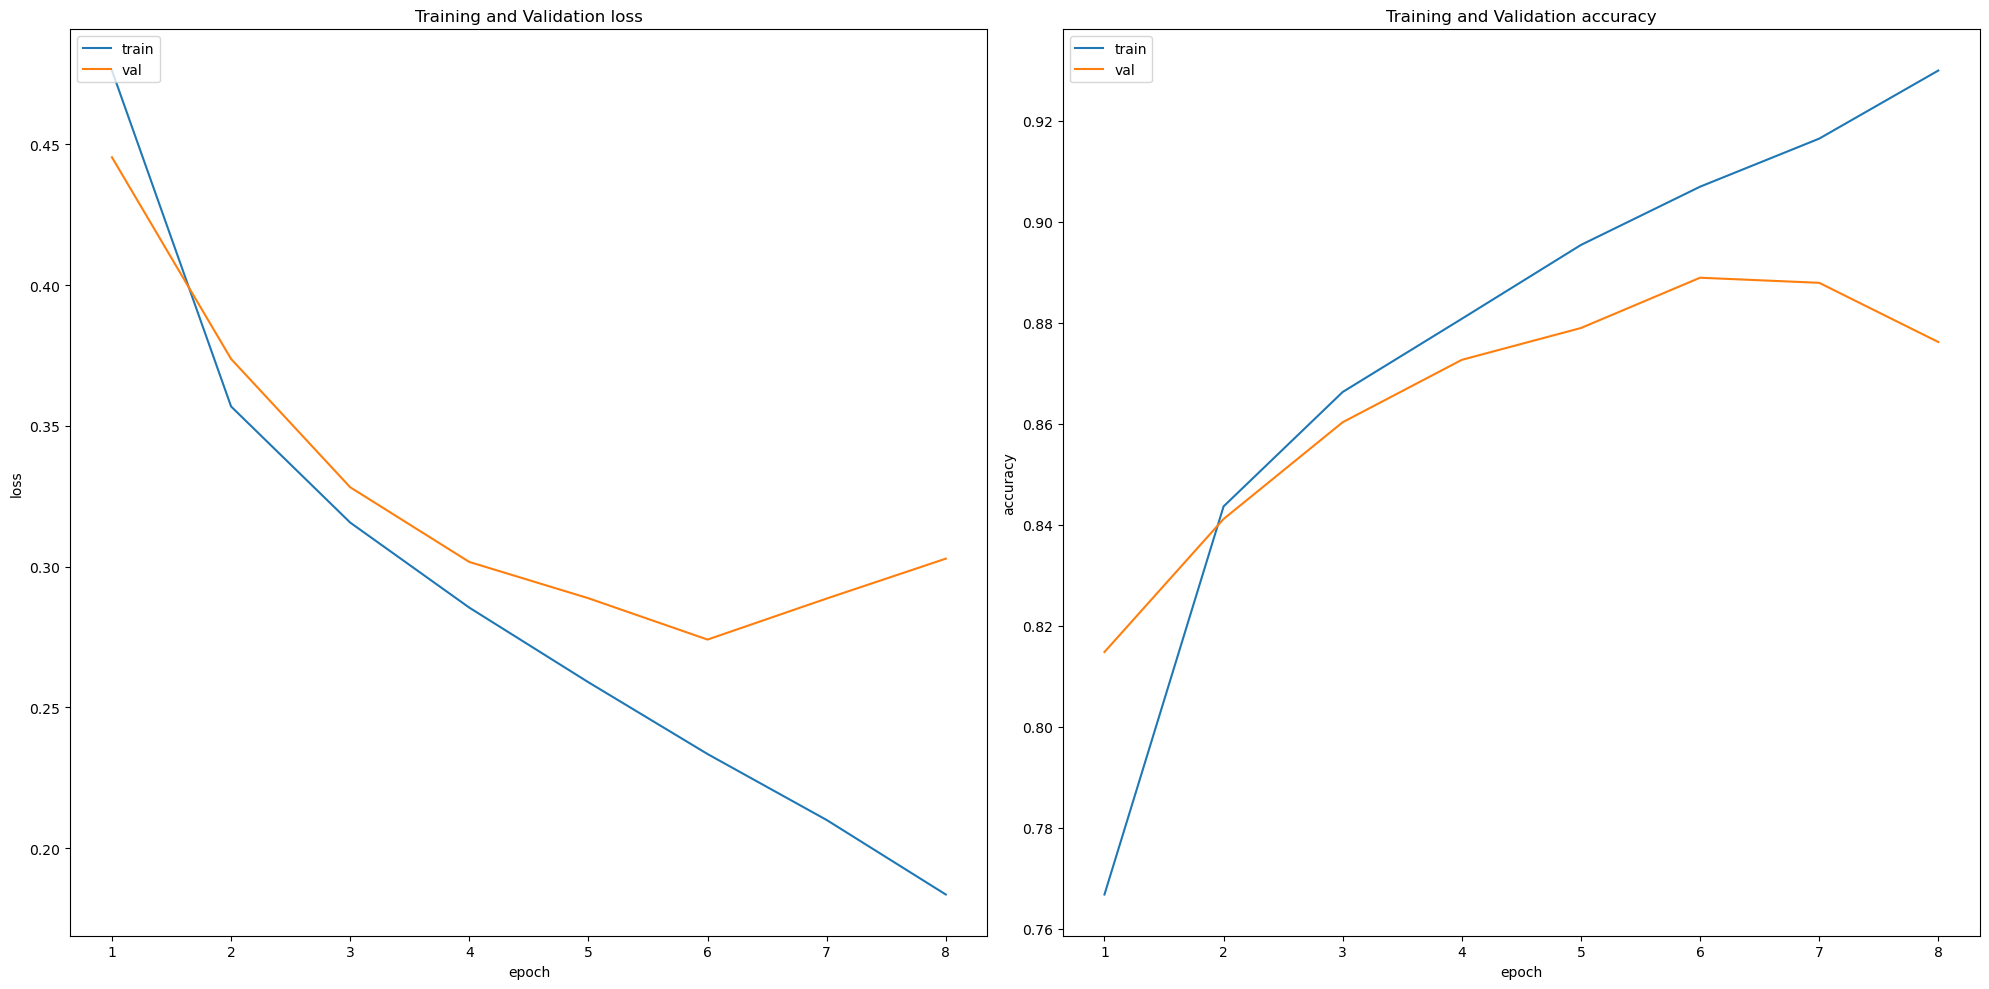

In [ ]:
epochRange = range(1,n_epochs+1)
fig , ax = plt.subplots(1,2,figsize = (20,10))

ax[0].plot(epochRange,hist.history['loss'],label = 'Training loss')
ax[0].plot(epochRange,hist.history['val_loss'],label = 'Validation loss')
ax[0].set_title('Training and Validation loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper left')
ax[1].plot(epochRange,hist.history['acc'],label = 'Training accuracy')
ax[1].plot(epochRange,hist.history['val_acc'],label = 'Validation accuracy')
ax[1].set_title('Training and Validation accuracy')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper left')
fig.tight_layout()
plt.show()

In [ ]:
result = model.evaluate(test_padded, y_test)
print("Model - Test Data")
print(dict(zip(model.metrics_names, result)))

Evaluate Model Performance on Test set
310/310 [==============================] - 14s 45ms/step - loss: 0.3010 - acc: 0.8717
{'loss': 0.3010288178920746, 'acc': 0.8717353940010071}


310/310 [==============================] - 14s 44ms/step


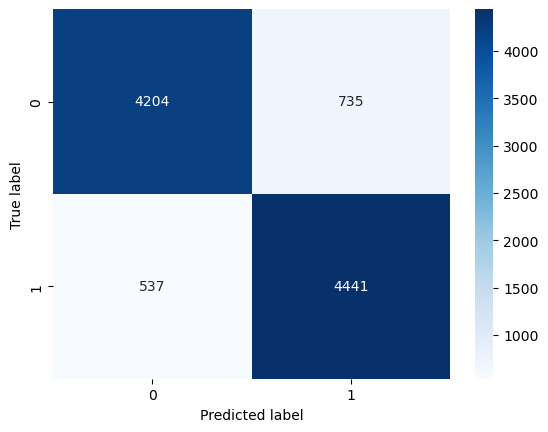

In [ ]:
ypred = model.predict(test_padded)
ypred = ypred>0.5
cf_matrix = confusion_matrix(y_test, ypred)
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()